(chap:5a-accounting)=
# 発展会計

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [2]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py4macro

## はじめに

一人当たりGDP（国内総生産）は経済の豊かさを示す一つの尺度として使われるが，下の左の図は2019年の世界経済での一人当たりGDPの分布を示している。日本と他の国・地域との比較を容易にするために、日本の一人当たりGDPを100として相対的な所得分布を表している。日本は38位で、１位であるルクセンブルグの一人当たりGDPは日本のそれより2倍強あり（米国は159.9で10位）、最下位のベネズエラは日本の一人当たりGDPの0.63％である。また、一人当たりGDPが日本の10％に満たない国・地域が107ある。こういった数字が示すように、世界の所得分布は大きな偏りがあり、非常に不平等である。

> （問１）なぜある国は豊かで他の国は貧しいのだろうか？

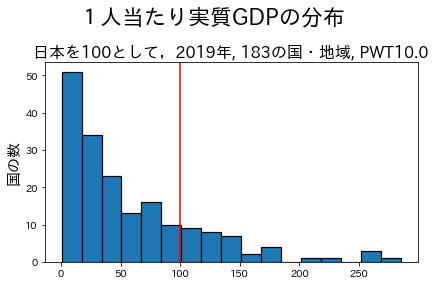

In [3]:
# データ
df = py4macro.data('pwt')

# 一人当たりGDP
df['GDPpc'] = df['rgdpe']/df['pop']

# 2019だけを取り出す
cond = (df['year'] == 2019)
df2019 = df.loc[cond, ['country','year','GDPpc']]

# 日本の値を抽出
jp = df2019.query('country=="Japan"')['GDPpc'].to_numpy()

# 日本を100として計算
df2019['GDPpc_normalized'] = 100*df['GDPpc']/jp

# プロット
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.hist(df2019['GDPpc_normalized'], bins=17, edgecolor='black', linewidth=1.2)
ax.axvline(100, c='red')
ax.set_ylabel('国の数', size=15)
ax.set_title(f'日本を100として，2019年, {len(df2019)}の国・地域, PWT10.0', size=16)
fig.suptitle(f'１人当たり実質GDPの分布', size=22)
pass

この問いはマクロ経済学の根本的な問いである。この重要な問題を考える上で、経済成長率に関する考察を無視できない。経済成長率とは、一人当たりGDP等の変数がある一定期間（例えば、一年間）にどれだけ変化したかをパーセントで表している。「現在の所得水準は過去に達成した成長率に依存し、またこれからの成長率が将来の所得水準を決定する」という質的な結果は直感的に理解できる。では、成長率と所得水準にはどういった量的な関係があるのだろうか。これを理解するために、{numref}`tab-growth`を見てみよう。


```{list-table} 現在の一人当たりGDPを100として
:name: tab-growth
:header-rows: 1

* - 成長率
  - 2.0%
  - 2.5%
  - 3.0%
* - 1年後
  - 102.0
  - 102.5
  - 103.0
* - 10年後
  - 121.9
  - 128.0
  - 134.4
* - 50年後
  - 269.2
  - 343.7
  - 438.4
* - 100年後
  - 724.5
  - 1181.4
  - 1921.9
```

現在の一人当たりGDPを100単位として，３つの異なる率で成長した場合、所得がどう変化するかを示している。2％と3％のケースを考えると、成長率が１％上昇するだけで、100年後の所得は約2.7倍に膨らんでいる。では、実際に各国の成長率はどれほど差があるのだろうか。それを示したのが次の図である。

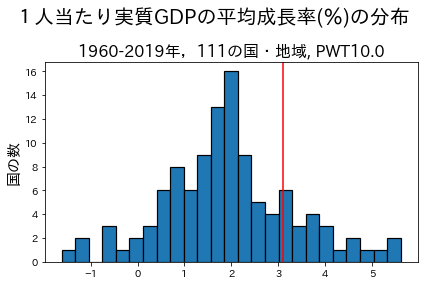

In [4]:
# 一人当たりGDP
df['naGDPpc'] = df['rgdpna']/df['pop']

# 1960を閾値とする
yr = 1960
df_growth = df.query('year >= @yr').copy()

# yr以降で全ての年でGDPのデータある国・地域を抽出
notna_check = lambda x: x.notna().all()
cond = df_growth[['country','year','naGDPpc']].groupby('country')['naGDPpc'].transform(notna_check)
df_growth = df_growth.loc[cond,:]

# 成長率の計算
def fun(col):
    return 100 * ( (col.iat[-1]/col.iat[0])**(1/len(col))-1 )
growth = df_growth.groupby('country')[['naGDPpc']].agg(fun)

# # 日本の平均成長率
jp_growth = growth.loc['Japan',:][0]

# # プロット
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.hist(growth, bins=25, edgecolor='black', linewidth=1.2)
ax.axvline(jp_growth, c='red')
ax.set_ylabel('国の数', size=15)
ax.set_title(f'{yr}-2019年，{len(growth)}の国・地域, PWT10.0', size=16)
fig.suptitle(f'１人当たり実質GDPの平均成長率(％)の分布', size=20)
pass

日本の平均成長率は3.1％であり、図では赤い直線で示している。最も高い成長率は台湾の5.61％であり，最も低い成長率はコンゴ民主共和国のマイナス1.62％である。実に、最高と最低成長率の差は7.23％ある。また、マイナスの成長率とは一人当たり所得の減少を意味するが、111の国・地域のうち8（約7.2％）が約60年の間平均して所得が縮小しているのである。

> （問２）なぜ国々の経済成長率は大きく異なるのか？

経済学者は、問１と２に対する完璧な答えを提示できておらず、今でも活発に研究がおこなわれている。この章ではまず問１についてデータと簡単な数式を使い議論する。特に，技術水準と蓄積生産要素（物的資本と人的資本）がどれだけ一人当たりGDPに貢献しているかを考え，その貢献度の違いを使い問１について考察する。

## データ

データは[Penn World Talbe 10.0](https://www.rug.nl/ggdc/productivity/pwt/?lang=en)を使うが，ここではデータをインポートするために`py4macro`モジュールを使う。このモジュールにはデータ・セットなどが含まれており，ここでは`data`関数を使ってデータをインポートする。使い方は次のコードで確認できる。

In [5]:
help(py4macro.data)

Help on function data in module py4macro.py4macro:

data(dataset=None, description=0)
    |
    | 引数：
    |     dataset: (文字列)
    |         'pwt':   Penn World Table 10.0
    |         'weo':   IMF World Economic Outlook 2021
    |         'mad':   country data of Maddison Project Database 2020
    |         'mad-regions':   regional data of Maddison Project Database 2020
    |         'jpn-q': 日本の四半期データ（GDPなど）
    |         'jpn-money': 日本の四半期データ（マネーストックなど）
    |         'world-money': 177ヵ国のマネーストックなど
    |         'ex': 円/ドル為替レートなど
    |
    |     description (デフォルト：0, 整数型):
    |         0: データのDataFrameを返す
    |            * 全てのデータセット
    |         1: 変数の定義を全て表示する
    |            * 全てのデータセット
    |         2: 変数の定義のDataFrameを返す
    |            * `'pwt'`，`'weo'``'mad'`のみ
    |        -1: 何年以降から予測値なのかを全て示す
    |            * `'weo'`のみ
    |        -2: 何年以降から予測値なのかを示すDataFrameを返す
    |            * `'weo'`のみ
    |
    | 返り値：
    |     DataFrame もしくは DataFrameの表示
    |
    | 例１：py4ma

````{note}
`py4macro`を事前にインストールする必要があるが，次のコマンドでインストールすることができる。
```
pip install py4macro
```
````

まず含まれていいる変数の定義を表示してみよう。`data()`の引数に`'pwt'`（文字列）と`description=1`を指定する。

In [6]:
py4macro.data('pwt',description=1)

,Variable definition
,
Identifier variables,NaN
countrycode,3-letter ISO country code
country,Country name
currency_unit,Currency unit
year,Year
"Real GDP, employment and population levels",NaN
rgdpe,Expenditure-side real GDP at chained PPPs (in mil. 2017US$)
rgdpo,Output-side real GDP at chained PPPs (in mil. 2017US$)
pop,Population (in millions)


`countrycode`は3つのアルファベットで表した標準的な国名コードであり，日本は`JPN`となる。よく使われるので，[このサイト](https://ja.wikipedia.org/wiki/ISO_3166-1)を参考に主な国の表記を覚えておくと良いだろう。

```{tip}
`description=1`は表示するだけなので，`DataFrame`として扱いたい場合は`description=2`とする。
```

`'pwt'`だけを引数に使うとデータ自体を読み込むことになる。

In [7]:
df = py4macro.data('pwt')

次に`.head()`を使って最初の5行を表示してみよう。

In [8]:
df.head()

,countrycode,country,oecd,income_group,region,continent,year,rgdpe,rgdpo,pop,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,0,High income,Latin America & Caribbean,North America,1950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,0,High income,Latin America & Caribbean,North America,1951,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,0,High income,Latin America & Caribbean,North America,1952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,0,High income,Latin America & Caribbean,North America,1953,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,0,High income,Latin America & Caribbean,North America,1954,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


次の変数は上の定義のリストには含まれていないので，ここで簡単に紹介する。
* `oecd`：1990年代に始まった中央ヨーロッパへの拡大前にOECDメンバー国であれば`1`，そうでなければ`0`
* `income_group`：世界銀行は所得水準に従って国を次の４つに分けている。
    * High income
    * Upper middle income
    * Lower middle income
    * Low income
* `region`：世界銀行が国・地域に従って分けた７つのグループ化
    * East Asia & Pacific
    * Europe & Central Asia
    * Latin America & Caribbean
    * Middle East & North Africa
    * North America
    * South Asia
    * Sub-Saharan Africa
* `continent`：南極以外の6大陸
    * Africa
    * Asia
    * Australia
    * Europe   
    * North America
    * South America

`2019`年のデータを使い内訳を確認してみよう。その際に便利なのが`DataFrame`と`Series`のメソッド`.value_counts()`である。これを使うと簡単に要素の個数や頻度を表示できる。

まず`oecd`を考えるが，条件に従って行を抽出しその数を数えてみる。

In [12]:
cond2019 = ( df['year']==2019 )
df.loc[cond2019,'oecd'].value_counts()

0    159
1     24
Name: oecd, dtype: int64

`oecd`には24カ国あることがわかる。

同様に`income_group`，`region`，`continent`の内訳を確認してみよう。

In [16]:
df.loc[cond2019,'income_group'].value_counts()

High income            65
Upper middle income    48
Lower middle income    44
Low income             24
Name: income_group, dtype: int64

In [17]:
df.loc[cond2019,'region'].value_counts()

Europe & Central Asia         48
Sub-Saharan Africa            45
Latin America & Caribbean     40
Middle East & North Africa    20
East Asia & Pacific           20
South Asia                     7
North America                  3
Name: region, dtype: int64

In [18]:
df.loc[cond2019,'continent'].value_counts()

Africa           50
Asia             48
Europe           39
North America    31
South America    12
Australia         3
Name: continent, dtype: int64

`.value_counts()`に引数`normalize=True`を追加すると，頻度（パーセント）として表示できる。

属性`.columns`を使い全ての列名を表示してみよう。

In [19]:
df.columns

Index(['countrycode', 'country', 'oecd', 'income_group', 'region', 'continent',
       'year', 'rgdpe', 'rgdpo', 'pop', 'emp', 'avh', 'hc', 'ccon', 'cda',
       'cgdpe', 'cgdpo', 'cn', 'ck', 'ctfp', 'cwtfp', 'rgdpna', 'rconna',
       'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta',
       'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr',
       'i_outlier', 'i_irr', 'cor_exp', 'statcap', 'csh_c', 'csh_i', 'csh_g',
       'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m',
       'pl_n', 'pl_k'],
      dtype='object')

また任意の列を選択するとメソッド`.unique()`が使えるようになる。これを使うことにより，選択した列に重複したデータがある場合，ユニークなものだけを抽出できる。このメソッドを使ってデータ・セットに含まれる国・地域名を確認してみよう。

In [20]:
country_list = df.loc[:,'country'].unique()
country_list

array(['Aruba', 'Angola', 'Anguilla', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia',
       'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia (Plurinational State of)', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Côte d'Ivoire", 'Cameroon', 'D.R. of the Congo', 'Congo',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Curaçao',
       'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt', 'Spain', 'Estonia', 'Ethiopia', 'Finland',
       'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana',
       'Guinea', 'Gambia', 'Guinea-Bissau', 'Equator

類似するメソッドに`.nunique()`がある。これを使うと，ユニークなデータの数を確認できる。

In [21]:
df.loc[:,'country'].nunique()

183

183の国・地域が含まれるということである。`unique()`でデータの年を確認することもできる。

In [22]:
year_list = df.loc[:,'year'].unique()
year_list

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

データを扱う際，必ずしもデータ・セットは完璧な形で提供されているわけではないことを念頭に置く必要がある。`df`の場合，必ずしも全ての国で全ての年のデータが揃っているわけではない。それを確認する必要があるが，役に立つのが`df`のメソッド`info()`である。

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   countrycode   12810 non-null  object 
 1   country       12810 non-null  object 
 2   oecd          12810 non-null  int64  
 3   income_group  12670 non-null  object 
 4   region        12810 non-null  object 
 5   continent     12810 non-null  object 
 6   year          12810 non-null  int64  
 7   rgdpe         10399 non-null  float64
 8   rgdpo         10399 non-null  float64
 9   pop           10399 non-null  float64
 10  emp           9529 non-null   float64
 11  avh           3492 non-null   float64
 12  hc            8637 non-null   float64
 13  ccon          10399 non-null  float64
 14  cda           10399 non-null  float64
 15  cgdpe         10399 non-null  float64
 16  cgdpo         10395 non-null  float64
 17  cn            10314 non-null  float64
 18  ck            7095 non-nul

この出力の読み方については[Pandasの章](https://py4basics.github.io/3_Pandas.html#id2)で解説したので，ここでリピートする必要はないと思うが，次の点が重要となる。
* 行のインデックスは`0`から`12809`まであり，合計`12810`行ある。`countrycode`をみると`12810 non-null`となっており，`non-null`は「非欠損値（欠損値ではない）」なので，その列には欠損値がないということを意味する。一方，`hc`は`8637 non-null`となっており，`12810-8637=4173`の欠損値が存在する。
* `float64`は浮動小数点型データであり，`object`は文字列のデータと考えて良いだろう。

しかし`object`に関しては少し注意が必要となる。列に文字列が１つ混じっていて，他は`float`であっても`object`となるので注意が必要である。次の例がそれを示している。

In [24]:
pd.DataFrame({'a':[1,2,3,4,5,'1']}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   a       6 non-null      object
dtypes: object(1)
memory usage: 176.0+ bytes


そしてもう一つ。`hc`には欠損値があると分かったが，その定義を個別で確認したい場合，`py4macro`の引数`description=2`を使うと`DataFrame`が返されるので，それを使うと良いだろう。

In [25]:
teigi = py4macro.data('pwt', description=2)
teigi.loc[['hc'],:]

,Variable definition
,
hc,"Human capital index, based on years of schooli..."


ただ，これだと定義の説明が全て表示できない。その場合は`py4macro.show()`関数を使うとフルに表示できる。

In [26]:
py4macro.show(teigi.loc[['hc'],:])

,Variable definition
,
hc,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."


```{note}
上のコードで`.loc['hc',:]`とすると`Series`が返されるので，表示が少し異なることになる。
```

実際にデータを使う前に，含まれているGDPの変数について簡単に説明する。世界中の経済のGDPを比較可能な形でデータを作成するのは非常に難しい。経済によって消費・生産・輸出・輸入する財の種類・量も違えば，価格も違う。それに購買力平価（PPPs; Purchasing Power Parities; [PWTで使うPPPs](https://www.worldbank.org/en/programs/icp)）を使って経済間のGDPを実質化したとしても，時系列的に実質化するには更なる調整が必要となる。またそれぞれの政府データを使う事になるが，大きく数字が修正される場合もある。このような問題に対処するために，PWTには５つのGDPの変数が提供されている。
* データにある年のPPPsに基づき経済間の価格の違いを考慮している。
    * `cgdpo`：産出データに基づいており，時系列的には名目。ある年で経済間の生産能力（**水準**）の比較に適している。
    * `cgdpe`：支出データに基づいており，時系列的には名目。ある年で経済間の生活**水準**の比較に適している。
    * `rgdpo`：産出データに基づいており，時系列的には実質。ある期間で経済間の生産能力（**水準**）の比較に適している。
    * `rgdpe`：支出データに基づいており，時系列的には実質。ある期間で経済間の生活**水準**の比較に適している。
* ある基準年のPPPsだけに基づき経済間の価格の違いを考慮している。
    * `rgdpna`：それぞれの経済の国民経済計算を使っており，時系列的には実質。GDPの**成長率**の比較に適している。

## 発展会計の考え方

経済間の所得格差の要因を探るために，次の生産関数を考えよう。

$$
Y_i=A_iK_i^\alpha\left(h_iH_iL_i\right)^{1-\alpha}
,\quad
0<\alpha<1
$$ (eq:5-production)

* $i$：経済`i`
* $Y_i$：GDP
* $K_i$：物的資本
* $A_i$：全要素生産性（TFP）
* $H_i$：労働者一人当たりの人的資本
* $h_i$：労働者一人当たりの平均労働時間
* $L_i$：労働者数

GDPは労働，物的人的資本とTFPによって決定されると考える，ということである。このアプローチは「大雑把」な印象を否めないが，データを使う事により，重要な知見を得ることが可能となる。次に，生産関数を一人当たりに書き換えよう。

$$
\frac{Y_i}{L_i}=A_i
\left(
    \frac{K_i}{L_i}
\right)^{\alpha}
\left(
h_iH_i
\right)^{1-\alpha}
\quad\Rightarrow\quad
y_i=A_ik_i^{\alpha}\left(h_iH_i\right)^{1-\alpha}
$$ (eq:5-yi)

この式を使い経済間の一人当たりGDPの違いを考察する事になる。即ち，$A_i$，$k_i$，$h_i$，$H_i$の違いを使って$y_i$の違いを説明しようという事である。以下では，$h_iH_i$と$k_i$，$h_i$，$H_i$を合わせた項を次のように呼ぶ事にする。

$$
\begin{align*}
&\text{（労働者一人当たり）人的資本サービス： } h_iH_i\\
&\text{（労働者一人当たり）蓄積生産要素： } k_i^{\alpha}\left(h_iH_i\right)^{1-\alpha}
\end{align*}
$$


使うデータ・セットには，$y_i$，$k_i$，$h_i$に対応する変数があり，蓄積生産要素がどれだけ一人当たりGDPに寄与するかを数値で表すことができる。一方，全要素生産性は次の式で求めることができる。

$$
A_i=\dfrac{y_i}{k_i^{\alpha}\left(h_iH_i\right)^{1-\alpha}}
$$ (eq:5-Ai)

これらの式とデータを使って，一人当たりGDPに対する蓄積生産要素と全要素生産性の寄与度を数量化する事になる。

```{note}
生産関数[](eq:5-production)の仮定のもとで$A_i$が上昇したとしよう。物的人的資本の限界生産性が上昇するため，$k_i$と$H_i$は増加することになる。即ち，$A_i$の上昇により一人当たりGDPは上昇するが，間接的に$k_i$と$H_i$も増加させ$y_i$が増加する。これにより本来$A_i$による効果が$k_i$と$H_i$の寄与度に算入されることになり，全要素生産性の寄与度の過小評価につながる可能性がある。この問題は練習問題で取り上げることにする。
```

データ・セットに含まれるどの変数を使うかという問題があるが，ここでは次のデータを使うことにする。
* `rgdpo`：生産面から計算したGDP（current PPPs; in mil. 2011US\$）
    * 経済間では一定な価格を使い計算されているが、時系列的には「名目」
    * ある年に経済間の比較をするのに適している
* `emp`：雇用者数（in millions）
* `avh`：年間平均労働時間
* `ck`：資本サービス水準（current PPPs (USA=1)）
    * 資本ストックを生産に使うことにより得るサービス    
    * USA=1と基準化されているが，米国との比率を考えるため，基準化による問題はなくなる。
    * データ・セットには次に２つが含まれている。
        * `cn`：資本ストック（current PPPs, in mil. 2011US\$，タクシーを例にすると車体の価額)。
        * `ck`：資本サービス（current PPPs, USA=1，タクシーを例にするとそのサービス（走行距離など）)。
* `hc`：一人当たり人的資本の指標
    * 教育年数と教育の収益から計算されている

式に当てはめると次のようになる。
* 一人当たりGDP：$y_i\equiv\dfrac{Y_i}{L_i}=$ `cgdpo`/`emp`
* 一人当たり資本：$k_i\equiv\dfrac{K_i}{L_i}=$ `ck`/`emp`
* 労働者一人当たり人的資本サービス：$h_iH_i=$ `avh`x`hc`
* 資本の所得シャア：$\alpha=1/3$を仮定

これに従ってコードを書いていこう。

In [ ]:
# 資本の所得シャア
a=1/3.0

# 労働者一人当たりGDP
df['gdp_pc'] = df['cgdpo'] / df['emp']

# 一人当たり資本
df['k_pc'] = df['ck'] / df['emp']

# 蓄積生産要素
df['factors'] = df['k_pc']**a * ( df['hc']*df['avh'] )**(1-a)

# 全要素生産性
df['tfp'] = df['gdp_pc'] / df['factors']

## 2019年

2019年だけを抽出する。

In [ ]:
df2019 = df.query('year == 2019').copy()

```{admonition} コードの説明
:class: dropdown

`df`から2019年だけ抽出後，`DataFrame`のメソッド`copy()`を使いそのコピーを作成し，それを左辺の`df2019`に割り当てている。ある警告が出ないようにするために`copy()`を使っている。さらに`Python`について学習した後に説明する事にする。
```

わかりやすくするために，全ての国の一人当たりGDPを米国の一人当たりGDPで割り、米国を１（基準）として議論を進める事にする。先に，米国だけのデータを抽出する。

In [ ]:
us2019 = df2019.query('country == "United States"')

次に，米国を基準とした相対的な一人当たりGDP作成し，`df2019`に新たな列として代入によう。

In [ ]:
df2019['gdp_pc_relative'] = df2019['gdp_pc'] / us2019['gdp_pc'].to_numpy()

```{admonition} コードの説明
:class: dropdown

`.to_numpy()`は`NumPy`の`array`に変換するメソッドである。`.to_numpy()`を省くと`Series`を`Series`で割る事になりエラーとなる。
```

### 物的資本

物的資本についても同様に，全ての国の`k_pc`を米国の`k_pc`で割り基準化する。

In [ ]:
df2019['k_pc_relative'] = df2019['k_pc'] / us2019['k_pc'].to_numpy()

データを散布図で確認しよう。

In [ ]:
df2019.plot(x='k_pc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があることが確認できる。またデータの曲線トレンドは凹関数のようである。`gdp_pc_relative`に対する`k_pc_relative`増加の影響は，`k_pc_relative`が低いと大きく，`k_pc_relative`が高いと小さくなる。即ち，資本の限界生産性の逓減の反映と考えられる。ただ，この効果のみで上の図を解釈するには問題がある。第一に，異なる経済のクロスセクション・データ（横断面データ）であるため，経済間の様々な異質性が反映されている。即ち，全ての観測値は同じ生産関数から生成されている訳ではない。第二に，資本の限界生産性の逓減という概念は，労働や他の投入が一定のもとでの比較静学の結果である。しかし，他の投入は一定に固定されている訳ではない。これらを考慮しつつ図の解釈をするべきではあるが，データの裏には資本の限界生産性の逓減のメカニズムが働いていると考えるのは自然であろう。

### 人的資本サービス

まず人的資本`hc`を考察する事にする。それにより労働時間`avh`の効果も理解できるだろう。
全ての国の`hc`を米国の`hc`で割り，米国を`1`とする人的資本インデックスを作成する。

In [ ]:
df2019['hc_relative'] = df2019['hc'] / us2019['hc'].to_numpy()

散布図で確認してみよう。

In [ ]:
df2019.plot(x='hc_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係があることがわかる。即ち，人的資本ストックが高ければ，一人当たり所得も増えるという事であり，非常に直感的でもある。一方，物的資本と比べると，曲線トレンドは凸関数になっている。裏にあるメカニズムとして様々なことが想定できる。
* 労働者のスキルが高いため，同じ時間でより多くの財を生産できる。
* 学習能力が高いため，生産活動をとおして更にスキル向上，生産性向上につながる（学習効果）。
* 人的資本には，人に教える能力も含まれる（例えば，教師）。それにより，さらなる人的資本ストックの増加につながる。
* 人から学ぶ能力も高いため，技術・知識の伝播の速度を速め，経済全体の生産性を向上させる。
* 新しい技術・知識の創出，即ち，イノベーションを起こす必要不可欠な要素である。
* 海外からの技術移転にも貢献する。
* リスクに対する理解が深まり，リスクは高いがより生産性が高い活動への投資につながる。
* などなど

ここで見えてくるのは人的資本の「外部性」の効果である。典型的な例が，学習効果である。人的資本が増えると，生産量が高くなり学習する機会が増え，更なる人的資本の増加につながる。それが更なる生産量の増加となり，相乗効果として凸関数トレンドとして現れていると解釈できる。また，能力が上がれば，それだけ新しい知識や技術をより簡単に吸収することが可能となるだろう。更には，周りに優れた人に囲まれて仕事や勉強をすれば，それに引っ張られて自分の能力も増してくる事になるのは多くの人が経験していることではないだろうか。労働者はこのような効果を意識して（例えば，他人への効果を考慮して）行動しているわけではない。即ち，外部性が一つの基本メカニズムとして働いているという解釈が成り立つ。

一方で，違う見方を可能である。閾値効果である。図を見ると，`h_relative`が低いところから増加しても`gdp_pc_relative`は大きく増加しないが，0.7あたりから増加率が増している。0.7付近で接続される２つの直線からなる折れ線グラフのようなトレンドが想定できるのではないだろうか。変数`hc`は，教育年数が一つの決定要因となっており，`hc`が低い経済では初等教育はある程度整っているが，高等教育が十分ではないと考えられる。従って，初等教育よりも高等教育の方が生産により大きな効果をもたらすとも考えられる。

人的資本の効果がある程度わかったので，次に人的資本サービスについて考えよう。全ての国の`hav`x`hc`を米国の`hav`x`hc`で割り基準化する。

In [ ]:
df2019['human_relative'] = ( df2019['avh']*df2019['hc'] ) / \
                           ( us2019['avh']*us2019['hc'] ).to_numpy()

散布図で確認してみよう。

In [ ]:
df2019.plot(x='human_relative', y='gdp_pc_relative', kind='scatter')
pass

正の関係であることは変わらないが，相関度は減少している。これは労働時間の影響であるり，一人当たりGDPとの散布図をプロットして確認してみよう。

In [ ]:
df2019['avh_relative'] = df2019['avh'] / us2019['avh'].to_numpy()

df2019.plot(x='avh_relative', y='gdp_pc_relative', kind='scatter')
pass

負の相関関係にあると言えるだろう。即ち，豊かな経済では労働時間が短くなる傾向にある。この傾向は，ミクロ経済学の授業で習った消費者の労働供給モデルを考えて解釈することができる。所得が上昇すると，所得効果により労働供給は減少するが，代替効果により労働時間は上昇する。上の図は，所得効果が代替効果を上回っている結果の反映と考えることが可能である。一方で，経済間では所得だけではなく他の要因も異なることも念頭においておこう。いずれにしろ，労働時間の負の関係により，人的資本サービスと一人当たりGDPの相関は弱くなっている。

### 全要素生産性

(sec:5a-tfp)=
### 全要素生産性

米国を`1`に基準化して一人当たりGDPと全要素生産性との関係を図示する。

In [ ]:
df2019['tfp_relative'] = df2019['tfp'] / us2019['tfp'].to_numpy()

df2019.plot(x='tfp_relative', y='gdp_pc_relative', kind='scatter')
pass

正の相関関係にあることは明らかであり，直線のトレンドであることがわかる。物的資本の場合は凹関数トレンドで，限界生産性の逓減の反映とも解釈できた。人的資本の場合は凸関数トレンドで，外部性の効果が示唆された。全要素生産性の直線トレンドの解釈はどうなるのだろう。まず，物的資本のように，限界生産性の逓減があれば凹型トレンドになるはずだが，それを抑えるメカニズムが働いていると考えられる。それが正の外部性の存在である。

全要素生産性は，蓄積生産要素で説明できない一人当たりGDPとして定義されているが，広く使われる解釈が技術水準である。技術水準はイノベーションなどにより決定され，外部性の役割が大きいと理解されている。それを説明するために，アイザック・ニュートンが言ったとされる次の引用を考えてみよう。

> If I have seen further, it is by standing on the shoulders of Giants.

ここでのhave seen furtherとはニュートンの天才的な能力・発見を指し，the shoulders of Giantsは先人が築き上げた知識・知見を意味する。ここで重要な点は，ニュートンは殆ど無料（書籍代や読書の機会費用はあるだろうが）で当時までに蓄積された知識を使うことができたということである。また多くの「先人」はニュートンがアイデアを参考にするとは想定していない，もしくはアイデアを使う対価を受け取っていないと思われれ，まさしく正の外部性が存在している（研究開発には負の外部性もある）。このようなことは，今でも発生している。新薬や新しいくゲーム・ソフトを作る場合，まず市場にある財を参考にする。知的財産権で守られているためコピー商品は違法だが，特許で開示されている技術やデザインなどを参考に新たな財を作り出すことは日常茶飯事である。この考えを使って上のデータを解釈してみよう。全世界的に技術水準が低ければ，他から学ぶ土壌が乏しく，TFPの一人当たりGDPに対する影響は限定的になる。一方，経済間の技術水準に大きな差がある場合，遅れている経済は進んでいる経済から学ぶことができる。更には，技術水準が高い経済同士も異なる考え方などをお互いから多くを学ぶ環境が存在することになる。これにより，TFPの効果はより大きなものとなって現れていると考えられ，技術水準の限界生産性の逓減が中和されることにより直線トレンドとしてあらわれていると解釈できる。

関連する問題として，生産関数の仮定と全要素生産性の関係について次の点を付け加えておく。TFPを計算する上でコブ・ダグラス生産関数を使ったが，規模に対して収穫一定を仮定している。もしこの仮定が間違っていて，規模に関して収穫逓増が正しい場合どのようなバイアスが発生するのだろうか。この点を明らかにするために，真の生産関数が次式で与えられるとしよう。

$$
Y_i=\tilde{A}_i\left(K_i^\alpha H_i^{1-\alpha}\right)^\mu,
\quad\mu>1
$$

$\mu=1$を仮定したわけだが，$\mu>1$の場合は規模に関して収穫逓増となる。$\tilde{A}_i$は真のTFPを指しており，$\mu=1$と$\mu>1$の場合のTFPの比率は次の式で表される。

$$
\dfrac{A_i}{\tilde{A}_i}
=\dfrac{
        \dfrac{Y_i}{K_i^\alpha H_i^{1-\alpha}}
        }{
        \dfrac{Y_i}{\left(K_i^\alpha H_i^{1-\alpha}\right)^\mu}
        }
=\left(K_i^\alpha H_i^{1-\alpha}\right)^{\mu-1}
>1
$$

$K_i^\alpha H_i^{1-\alpha}>1$と考えると，収穫一定のTFPは真のTFPを過大評価する事がわかる。何が起こっているのだろうか。$\mu>1$の場合に収穫一定を仮定すると，

$$
K_i^\alpha H_i^{1-\alpha}
<
\left(K_i^\alpha H_i^{1-\alpha}\right)^\mu
$$

となり，蓄積生産要素の効果が過小評価されることになる。これにより物的人的資本の効果の一部をTFPの貢献だと間違って判断しTFPの過大評価になっている。では，なぜ規模に関して収穫逓増になり得るのだろうか。それが技術水準や蓄積生産要素の外部性である。技術水準と人的資本の外部性について簡単に説明したが，物的資本ストックも外部性を発生させると考えられる。物的資本ストックが増えると一人当たりGDPを増加させる。それにより，人的資本の学習効果を強める事になる。また研究開発のヒントを与えるようなきっかけにもなるかもしれない。そのような相乗効果により規模に関して収穫逓増になる生産関数を想定することも可能である。しかし多くの研究では規模に関して収穫一定の下で議論が進められており，以下ではそれを踏襲して$\mu=$とする。

### 相関係数

一人当たりGDPと全要素生産性の散布図から，両変数の相関度は非常に高いと思われる。相関係数を計算してみよう。

In [ ]:
df2019.loc[:,['gdp_pc_relative','tfp_relative']].dropna().corr()

```{admonition} コードの説明
:class: dropdown

* `.dropna()`は`NaN`がある行を削除するメソッド

*`.corr()`は相関係数を計算するメソッド
```

In [ ]:
from myst_nb import glue
corr_gdp_pc_relative_tfp_relative = df2019.loc[:,['gdp_pc_relative','tfp_relative']].dropna().corr().loc['gdp_pc_relative','tfp_relative']
glue("corr_gdp_pc_relative_tfp_relative", round(corr_gdp_pc_relative_tfp_relative,3),display=False)

`GDPpc_relative`と`tfp_relative`の相関係数は約{glue:}`corr_gdp_pc_relative_tfp_relative`であり、非常に高いことがわかる。

次に，蓄積生産要素と一人当たりGDPの散布図を作成し，相関係数を計算してみよう図示する。

In [ ]:
df2019['factors_relative'] = df2019['factors'] / us2019['factors'].to_numpy()

df2019.plot(x='factors_relative', y='gdp_pc_relative', kind='scatter')
pass

視覚的には，TFPと比べて相関度は低いようである。コードで確認しよう。

In [ ]:
df2019.loc[:,['gdp_pc_relative','factors_relative']].dropna().corr()

TFPより相関係数は低いことが確認できた。

## 全要素生産性と蓄積生産要素の寄与度

(sec:5-tfp-factors)=
## 全要素生産性と蓄積生産要素の寄与度

全要素生産性と蓄積生産要素はそれぞれ一人当たりGDPにどれだけ寄与しているかを考えるために，次の方法を考える。まず生産関数を使い以下を定義する。

$$
R_i^y=R_i^{\text{tfp}}R_i^{\text{factors}}
$$

ここで

$$
R_i^y\equiv\dfrac{y_i}{y_{\text{US}}},\quad
R_i^{\text{tfp}}\equiv\dfrac{A_i}{A_{\text{US}}},\quad
R_i^{\text{factors}}\equiv
\dfrac{k_i^a\left(h_iH_i\right)^{1-a}}{k_{\text{US}}^a\left(h_{\text{US}}H_{\text{US}}\right)^{1-a}}
$$

1. $R_i^y$：米国を基準とした相対所得
1. $R_i^{\text{tfp}}$：米国を基準とした相対全要素生産性
1. $R_i^{\text{factors}}$：米国を基準とした相対蓄積生産要素

まず両辺に対数を取ると次式となる。

$$
r_i^y =
r_i^{\text{tfp}} +
r_i^{\text{factors}}
$$ (eq:riy-decomposition)

ここで，

$$
r_i^y\equiv \log\left(R_i^y\right),\quad
r_i^{\text{tfp}}\equiv\log\left(R_i^{\text{tfp}}\right),\quad
r_i^{\text{factors}}\equiv\log\left(R_i^{\text{factors}}\right)
$$


次に式[](eq:riy-decomposition)の両辺の分散を計算するが，次の関係が成立することを思い出そう。

$$
\text{Var}(a+b)= \text{Var}(a)+ \text{Var}(b)+2\text{Cov}(a,b)
$$ (eq:var_a+b)

式[](eq:var_a+b)を使うと[](eq:riy-decomposition)は次のように書き換えることができる。

$$
\text{Var}\left(r_i^y\right) =
\text{Var}\left(r_i^{\text{tfp}}\right) +
\text{Var}\left(r_i^{\text{factors}}\right) +
2\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
$$ (eq:VARriy-decomposition)


式[](eq:VARriy-decomposition)は左辺の相対所得の変動は右辺の３つの項に分解することができることを示している。
* $\text{Var}\left(r_i^{\text{tfp}}\right)$：全要素生産性（対数; 米国＝１）の変動
* $\text{Var}\left(r_i^{\text{factors}}\right)$：蓄積生産要素（対数; 米国＝１）の変動
* $\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)$：全要素生産性と相対蓄積生産要素の共分散（それぞれ対数; 米国＝１）

更に，[](eq:VARriy-decomposition)の両辺を$\text{Var}(r_i^y)$で割ると，次のように書くことができる。

$$
1= \text{全要素生産性の寄与度}
+\text{蓄積生産要素の寄与度}
$$

ここで

$$
\text{全要素生産性の寄与度}=
\dfrac{
    \text{Var}\left(r_i^{\text{tfp}}\right)
    +\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
    }{
    \text{Var}(r_i^y)
    }
$$ (eq:tfp-contribution)


$$
\text{蓄積生産要素の寄与度}=
\dfrac{
    \text{Var}\left(r_i^{\text{factors}}\right)
    +\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
    }{
    \text{Var}(r_i^y)
    }    
$$ (eq:factor-contribution)

と定義する。$2\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)$ は等分されている。

（考え方）

式[](eq:tfp-contribution)と[](eq:factor-contribution)の分母は$\log(R_i^y)$の分散であり，それに対して分子はどれだけ変動しているかで寄与度を計算しようということである。分母に対して分子の変動が大きければ大きい程，説明力が高いと判断するわけである。極端な例として、全ての経済の全要素生産性が同じで蓄積生産要素だけが異なる場合を考えてみよう。即ち，

$$
\text{Var}\left(r_i^{\text{tfp}}\right)=0\quad\Rightarrow\quad
\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
=0
$$

この場合、蓄積生産要素だけで一人当たりGDPの違いを説明できることになるため、全要素生産性の寄与度は`0`であり蓄積生産要素は`1`である。即ち、全要素生産性は変化しないため一人当たりGDP（対数）の分散を説明できないが，一方，蓄積生産要素の変動のみで一人当たりGDPの変動を説明している事になる。

In [ ]:
# 欠損値であるNaNがある行を削除
df2019_nonan = df2019.dropna(subset=['gdp_pc_relative','tfp_relative', 'factors_relative'])

# それぞれの変数（対数）を設定
tfp     = np.log(df2019_nonan['tfp_relative'])
factors = np.log(df2019_nonan['factors_relative'])
gdp_pc  = np.log(df2019_nonan['gdp_pc_relative'])

# 分散・共分散の計算
tfp_var         = tfp.var()
factors_var     = factors.var()
gdp_pc_var      = gdp_pc.var()
tfp_factors_cov = np.cov(tfp.values,factors.values)[0,1]

```{admonition} コードの説明
:class: dropdown

１行目で使った`.dropna()`は，引数なしでそのまま使うと１つでも`NaN`がある行は削除される。引数の`subset=[]`に列を指定すると，その列に`NaN`がある行だけが削除される。
```

**全要素生産性の寄与度**

In [ ]:
(tfp_var + tfp_factors_cov) / gdp_pc_var

In [ ]:
from myst_nb import glue
contribution_of_tfp = (tfp_var + tfp_factors_cov) / gdp_pc_var
glue("contribution_of_tfp", int(100*round(contribution_of_tfp,2)),display=False)

**蓄積生産要素の寄与度**

In [ ]:
(factors_var + tfp_factors_cov) / gdp_pc_var

In [ ]:
from myst_nb import glue
contribution_of_factors = (factors_var + tfp_factors_cov) / gdp_pc_var
glue("contribution_of_factors", int(100*round(contribution_of_factors,2)),display=False)

**結果**

2019年の一人当たりGDPの変動の約{glue:}`contribution_of_tfp`%は全要素生産性によって説明され，残りの{glue:}`contribution_of_factors`%は蓄積生産要素によって説明される。即ち，一人当たりGDPの決定要因としての全要素生産性は蓄積生産要素は重要性は同等もしくはそれ以上である。

## 表の作成

最後に、主要な国のデータを表にまとめてみる。

In [ ]:
# 1
country_table = ['Japan', 'United Kingdom','United States', 'Norway',
                'Mexico','Peru','India','China','Zimbabwe','Niger']

# 2
cond = df2019['country'].isin(country_table)

# 3
col = ['country','gdp_pc_relative','tfp_relative','factors_relative']

# 4
table2019 = df2019.loc[cond,col].set_index('country') \
                  .sort_values('gdp_pc_relative', ascending=False) \
                  .round(2) \
                  .rename(columns={'gdp_pc_relative':'一人当たりGDP',
                                   'tfp_relative':'全要素生産性',
                                   'factors_relative':'蓄積生産要素'})

print('米国を１として')
table2019

```{admonition} コードの説明
:class: dropdown

1. 表示する国のリスト
2. 列`country`に`country_list`にある国名と同じであれば`True`、異なる場合は`False`を返す条件を作成している。
    * `.isin()`はそのためのメソッド
3. 表の列ラベルに使う変数リスト
4. `DataFrame`を作成する。
    * `.loc[cond,col]`を使い、`cond`の条件に合った行、そして`col`の列を抽出する。
    * `.set_index('country')`は`country`の列を行ラベルに設定するメソッド。
    * `.sort_values()`は`DataFrame`を列`gdp_pc_relative`に従って並び替えるメソッドであり、`ascending=False`は降順を指定している。
    * `.round(2)`は表示する小数点を第二桁までで四捨五入することを指定するメソッド。
    * `.rename()`は列ラベルを変更するメソッド。
    
＜コメント＞ `print()`関数を使うとテキストとして表示される。
```

In [ ]:
from myst_nb import glue
tfp_jp_relative_to_us = int(table2019.loc['Japan','全要素生産性']*100)
glue("tfp_jp_relative_to_us", tfp_jp_relative_to_us,display=False)
factors_jp_relative_to_us = int(table2019.loc['Japan','蓄積生産要素']*100)
glue("factors_jp_relative_to_us", factors_jp_relative_to_us,display=False)

この表から日本の全要素生産性は米国の{glue:}`tfp_jp_relative_to_us`%であり，蓄積生産要素は米国の{glue:}`factors_jp_relative_to_us`%であることが分かる。